In [1]:
import numpy as np
import cv2 # OpenCV biblioteka
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
CARD_MIN_HW = 300
CARD_MAX_HW = 2000
EPSILON = 0.05
CROP_Y0 = 5
CROP_H = 72
CROP_X0 = 2
CROP_W = 22
SEPARATE_CROP_Y = 37
CROP_THRESHOLD = 150

In [3]:
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = 16,12

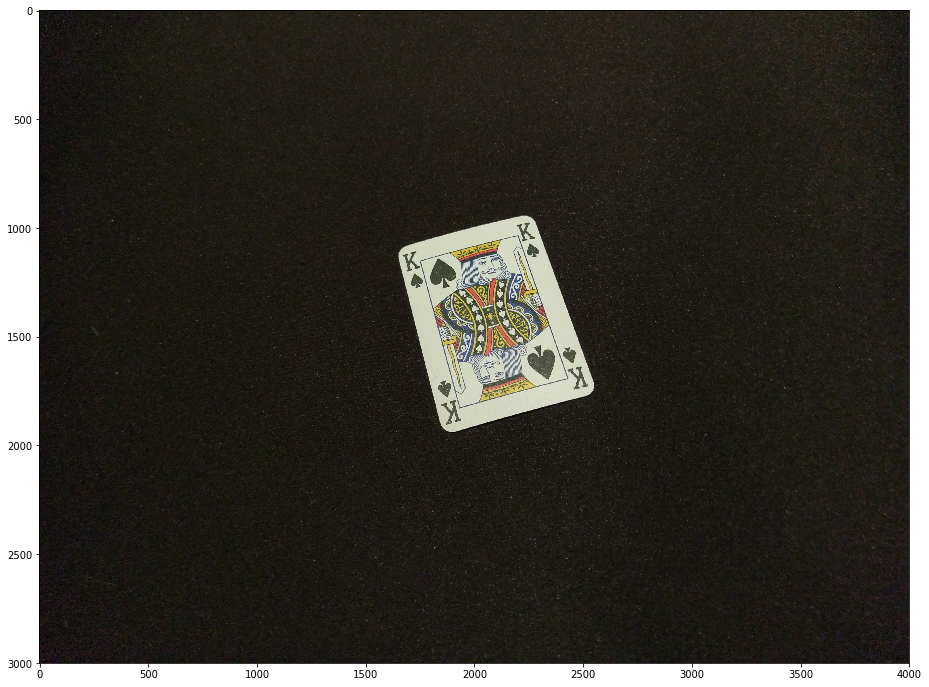

In [4]:
img = cv2.imread('test/IMAG1001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

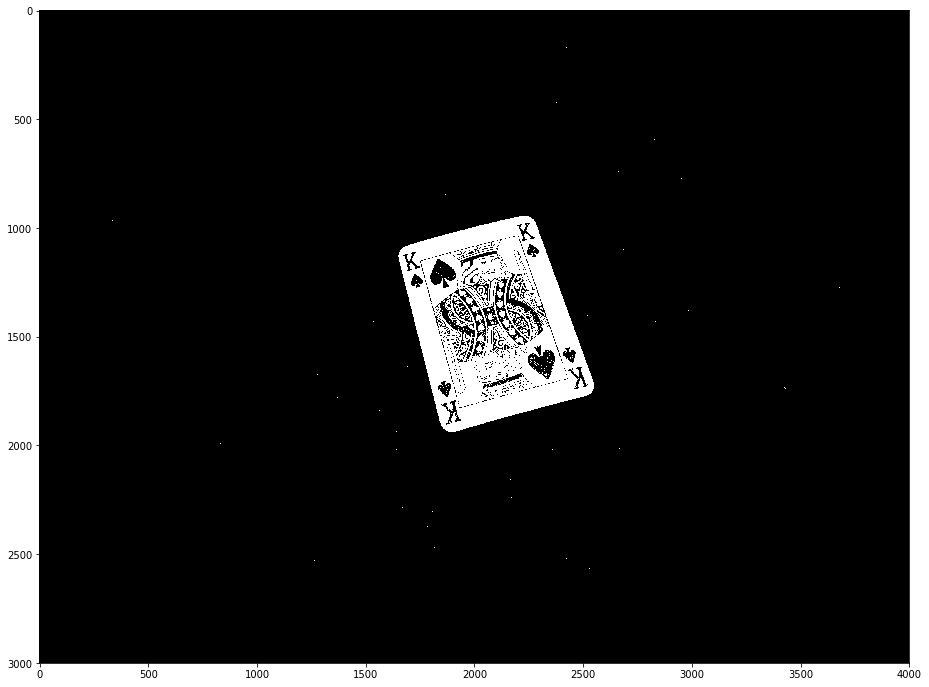

In [5]:
img_gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#img_bin = cv2.Canny(img,150,250)
ret, img_bin = cv2.threshold(img_gs, 100,255,cv2.THRESH_BINARY)

plt.imshow(img_bin, 'gray')

730.238525390625 886.5302734375 4 [2618  202  204   -1]


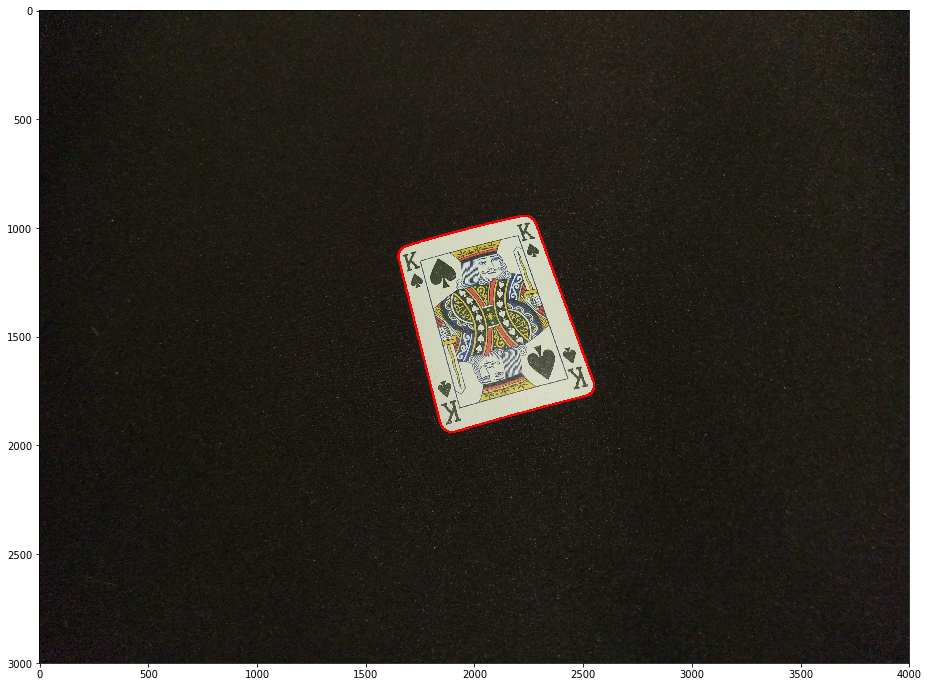

In [14]:
img1, contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_card = []
i = 0
for contour in contours:
    center, size, angle = cv2.minAreaRect(contour)
    width, height = size
    epsilon = EPSILON * cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,epsilon,True)
    if width > CARD_MIN_HW and width < CARD_MAX_HW and height > CARD_MIN_HW and height < CARD_MAX_HW and len(approx) == 4 and hierarchy[0][i][3] == -1:
        print(width, height, len(approx), hierarchy[0][i])
        contours_card.append(contour) # ova kontura pripada bar-kodu
    i += 1

image_show = img.copy()
cv2.drawContours(image_show, contours_card, -1, (255, 0, 0), 10)
plt.imshow(image_show)

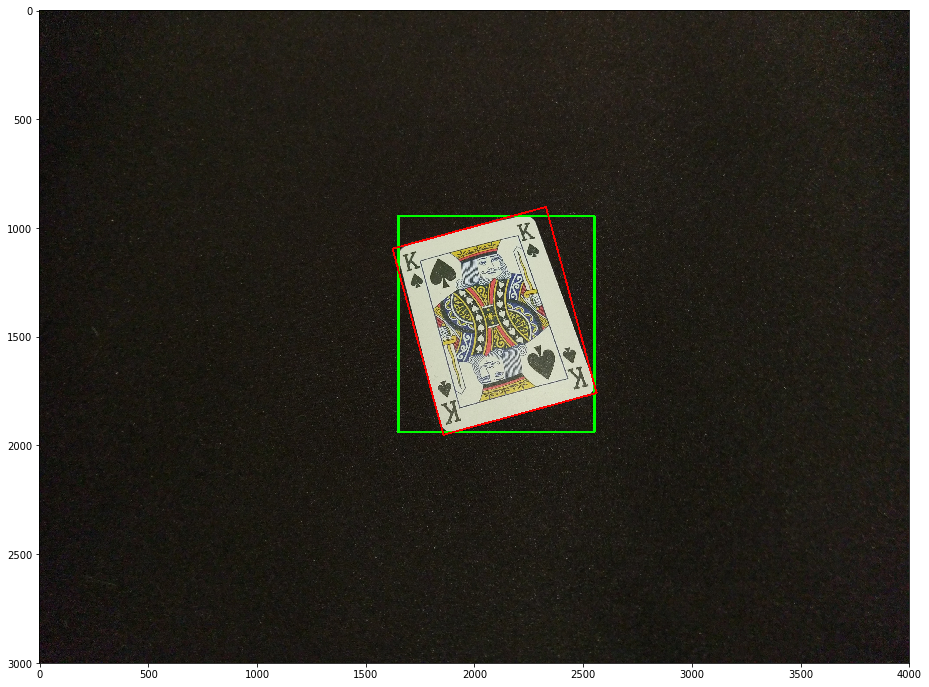

In [15]:
trazena_kontura = contours_card[0]
x,y,w,h = cv2.boundingRect(trazena_kontura)
image_show = img.copy()
cv2.rectangle(image_show,(x,y),(x+w,y+h),(0,255,0),10)
rect = cv2.minAreaRect(trazena_kontura)
rect = cv2.boxPoints(rect)
rect = np.int0(rect)
cv2.drawContours(image_show,[rect],0,(255,0,0),8)
plt.imshow(image_show)

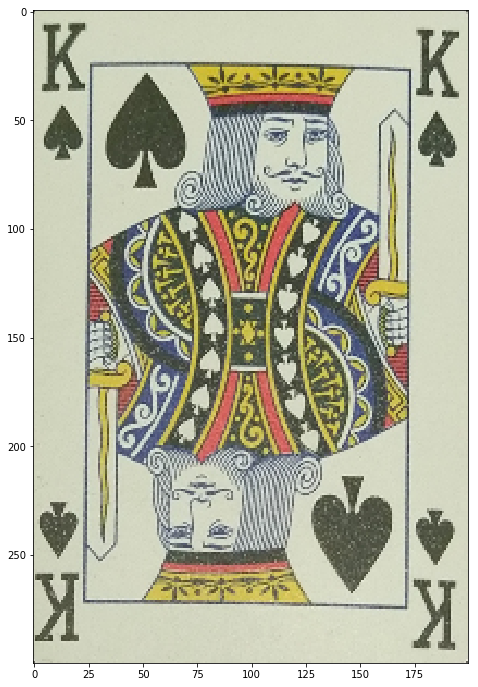

In [8]:
epsilon = EPSILON * cv2.arcLength(trazena_kontura,True)
approx = cv2.approxPolyDP(trazena_kontura,epsilon,True)
pts = [[approx[0][0][0], approx[0][0][1]], [approx[1][0][0], approx[1][0][1]], [approx[2][0][0], approx[2][0][1]], [approx[3][0][0], approx[3][0][1]]]
pts = np.float32(pts)

temp_rect = np.zeros((4,2), dtype = "float32")

xSorted = pts[np.argsort(pts[:, 0]), :]
 
leftMost = xSorted[:2, :]
rightMost = xSorted[2:, :]
 
leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
(tl, bl) = leftMost

D = distance.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
(br, tr) = rightMost[np.argsort(D)[::-1], :]

if distance.euclidean(bl,br) >= distance.euclidean(bl,tl):
    temp_rect[0] = bl
    temp_rect[1] = tl
    temp_rect[2] = tr
    temp_rect[3] = br
else:
    temp_rect[0] = tl
    temp_rect[1] = tr
    temp_rect[2] = br
    temp_rect[3] = bl
maxWidth = 200
maxHeight = 300

dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
M = cv2.getPerspectiveTransform(temp_rect,dst)
warp = cv2.warpPerspective(img, M, (maxWidth, maxHeight))

plt.imshow(warp)


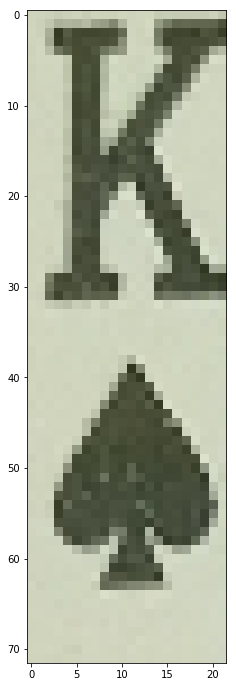

In [9]:
crop_warp = warp[CROP_Y0:CROP_Y0 + CROP_H, CROP_X0:CROP_X0 + CROP_W]
plt.imshow(crop_warp)

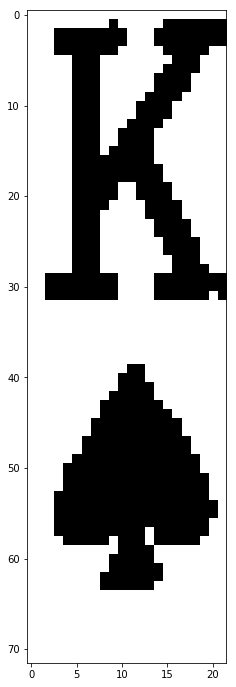

In [10]:
crop_gs = cv2.cvtColor(crop_warp, cv2.COLOR_RGB2GRAY) # konvert u grayscale
ret, crop_bin = cv2.threshold(crop_gs, CROP_THRESHOLD,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(crop_bin, 'gray')

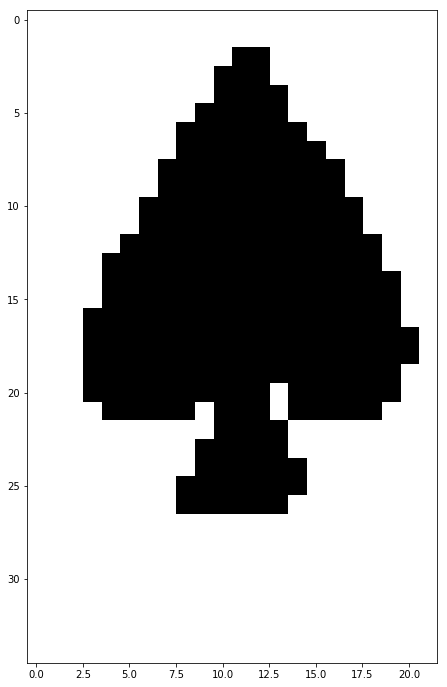

In [16]:
znak_crop = crop_bin[0:SEPARATE_CROP_Y, 0:CROP_W]
boja_crop = crop_bin[SEPARATE_CROP_Y:CROP_H, 0:CROP_W]
#plt.imshow(znak_crop, 'gray')
plt.imshow(boja_crop, 'gray')

In [12]:
def localize_suit(image):
    inv_image = cv2.bitwise_not(image)
    img, contours, hierarchy = cv2.findContours(inv_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    region = None
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        if w > 8 and h > 8:
            region = img[y:y+h+1,x:x+w+1]
            break
    if region is not None:
        return region
    else:
        return image
    
def localize_rank(image):
    inv_image = cv2.bitwise_not(image)
    img, contours, hierarchy = cv2.findContours(inv_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    region = None
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        if w > 8 and h > 10:
            region = img[y:y+h+1,x:x+w+1]
            break
    if region is not None:
        return region
    else:
        return image

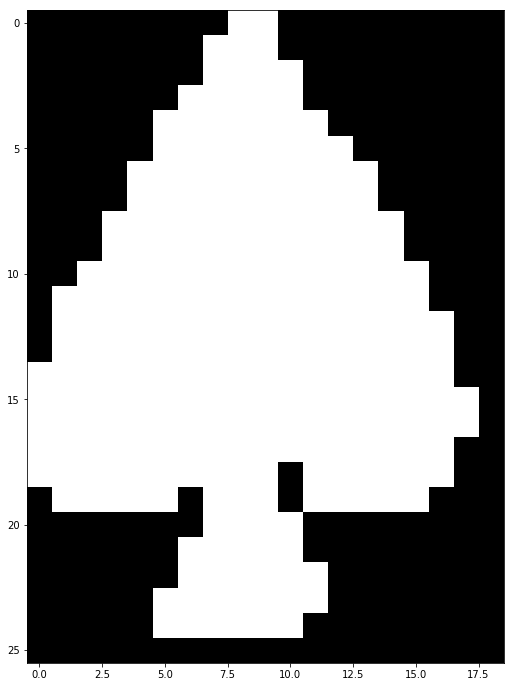

In [13]:
nimg = localize_suit(boja_crop)
plt.imshow(nimg, 'gray')